# Final Checks for model

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
df = pd.read_csv(f"D:/Docs/train_2.csv", encoding='mac_roman')

In [24]:
df.head(3)

,ticket_id,agency_name,city,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department",CHICAGO,250.0,20,10,25.0,0,0,305.0,0.0,305.0,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department",Detroit,750.0,20,10,75.0,0,0,855.0,780.0,75.0,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department",DETROIT,250.0,0,0,0.0,0,0,0.0,0.0,0.0,not responsible by disposition,NaN


In [25]:
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
df["city_code"] = ord_enc.fit_transform(df[["city"]])
df[["city", "city_code"]].head(3)

,city,city_code
0,CHICAGO,682.0
1,Detroit,1204.0
2,DETROIT,1104.0


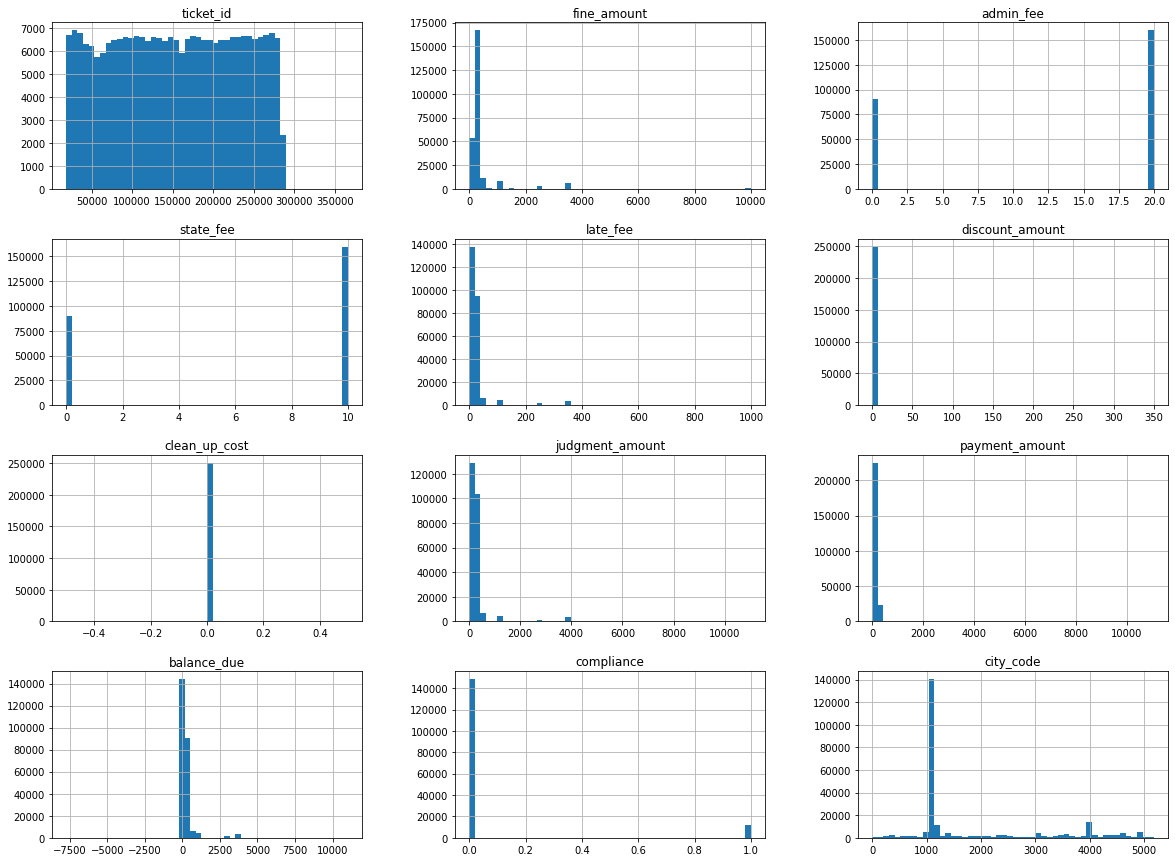

In [26]:
df.hist(bins = 50, figsize = (20, 15))
plt.show()

## 1. Use ONLY compliance available columns

In [27]:
df = df[df['compliance'].notna()]
df.shape

(159880, 15)

In [28]:
df['fine_amount'] = df['fine_amount'].fillna(0)
df.shape

(159880, 15)

In [29]:
df['compliance'].value_counts()

0.0    148283
1.0     11597
Name: compliance, dtype: int64

## 2. Build the actual model

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
feature_names_tickets = ['fine_amount', 'late_fee', 'judgment_amount']
X_tickets = df[feature_names_tickets]
y_tickets = df['compliance']

#Test size is chosen to get X_test value of 61,001 as the same is provided test data
X_train, X_test, y_train, y_test = train_test_split(X_tickets, y_tickets, test_size = 0.38153900, random_state = 0)
clf = LogisticRegression(C=100).fit(X_train, y_train)
print(X_train.shape)
print(X_test.shape)

(98879, 3)
(61001, 3)


## 3. Apply GridSearchCV

In [32]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid,
                           scoring = 'accuracy', cv = 5, verbose=0)
grid_search.fit(X_train, y_train)
print('Best C-value:\n Best C: {}'.format(grid_search.best_score_))

Best C-value:
 Best C: 0.9280433630364252


In [33]:
#Fit based on new model now
clf_best = LogisticRegression(C = 1).fit(X_train, y_train)

## 4. Check ROC / AUC (Main test split)

<ipython-input-36-a1b720178bab>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


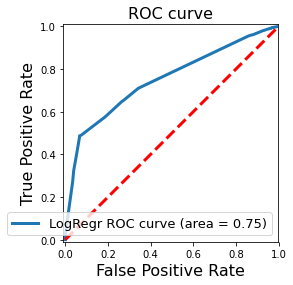

In [36]:
from sklearn.metrics import roc_curve, auc
y_score_lr = clf_best.decision_function(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='red', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

## 5. Check ROC / AUC (Real Test Data)

In [40]:
# First we need to load our test dataset
df1 = pd.read_csv(f"D:/Docs/test_2.csv", encoding='mac_roman')
df1.shape


(61001, 8)

In [41]:
df1.head(5)

,ticket_id,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount
0,284932,200,20,10,20.0,0,0,250.0
1,285362,1000,20,10,100.0,0,0,1130.0
2,285361,100,20,10,10.0,0,0,140.0
3,285338,200,20,10,20.0,0,0,250.0
4,285346,100,20,10,10.0,0,0,140.0


In [42]:
feature_names_test = ['fine_amount', 'late_fee', 'judgment_amount']
X_test_new = df1[feature_names_test]
print(X_test_new.shape)

(61001, 3)


<ipython-input-43-ef0c7629b168>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


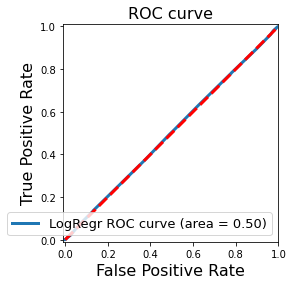

In [43]:
from sklearn.metrics import roc_curve, auc
y_score_lr = clf_best.decision_function(X_test_new)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='red', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

In [45]:
score = clf_best.score(X_test, y_test)
print(score)

0.9287060867854625


In [46]:
predictions = clf_best.predict(X_test)
predictions.shape

(61001,)

In [47]:
print(predictions.sum())

319.0


In [48]:
pred_values = pd.DataFrame(predictions) 
#pred_values.to_csv('result_pred.csv')

In [49]:
pred_values.value_counts()

0.0    60682
1.0      319
dtype: int64